In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from multiprocessing import Pool
import inspect
import pickle

from evolver import Evolver
from models import Model3, Model1_2, Model2, Model1_1
from util_funs import find_initial_params, read_files, filter_data, get_run_id, emcee_analysis

np.random.seed(12345)

%load_ext autoreload
%autoreload 2

# True if you want to read from the dataset files, False if you want to generate the date with the model
USE_DATASET = False

Best time range is [0, 3]


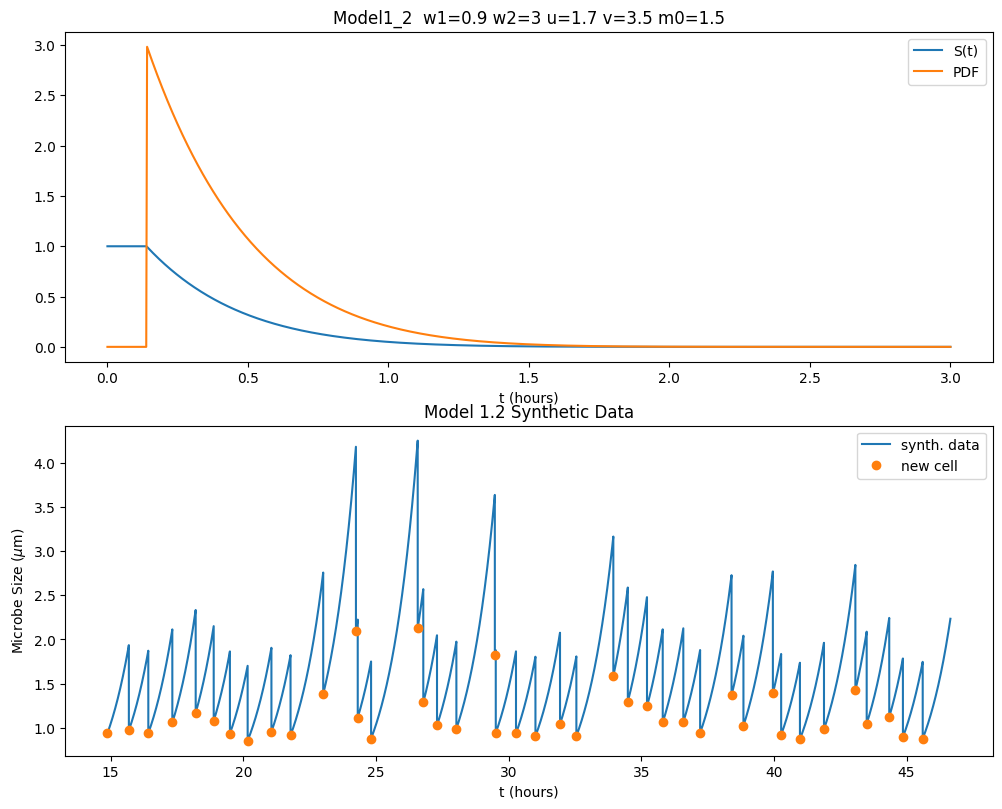

In [209]:
if not USE_DATASET:
    # m0, w1, w2, u, v = 3, 2, 3, 0.8, 2
    # m0, w1, w2, u, v = 2.5, 2.5, 3, 10, 12
    # m0, w1, w2, u, v = 2.5, 0.5, 6, 1.7, 3.5
    m0, w1, w2, u, v = 1.5, 0.9, 3, 1.7, 3.5
    # m0, w1, w2, u, v = 1.5, 2, 4, 1.7, 3.5
    model = Model1_2(m0=m0, w1=w1, w2=w2, u=u, v=v)

    # Plot the model
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    model.get_figure(axs[0])

    # Here we make the model evolve (and divide)
    n_generations = 400
    evolver = Evolver(model=model)
    evolver.evolve(n_generations, debug=False)

    # Here we show some of the result
    start_gen = 20
    end_gen = 60
    time, data = evolver.get_data(start_gen, end_gen)
    final_time, final_data = evolver.get_start_data(start_gen, end_gen)

    ptime = evolver.time[evolver.offset_start[start_gen]: evolver.offset_end[end_gen] + 1]
    params = evolver.params[evolver.offset_start[start_gen]: evolver.offset_end[end_gen] + 1]

    axs[1].plot(time, data[:, 0])
    axs[1].set_title('Model 1.2 Synthetic Data')
    axs[1].set_xlabel('t (hours)')
    axs[1].set_ylabel('Microbe Size ($\mu$m)')
    axs[1].plot(final_time, final_data[:, 0], marker='o', linestyle='')
    axs[1].legend(['synth. data', 'new cell']);

100%|██████████| 5000/5000 [03:52<00:00, 21.47it/s]


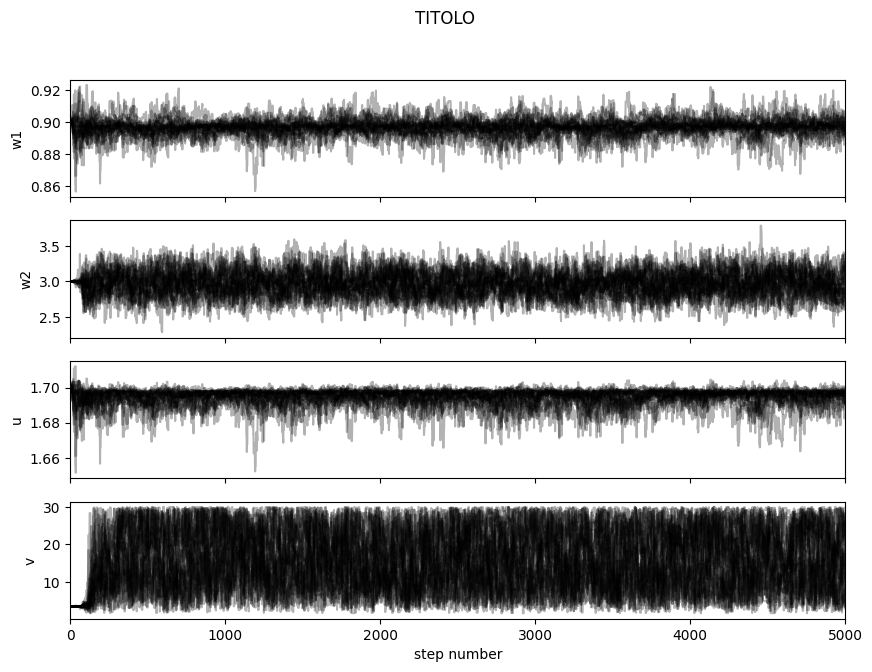

Auto correlation time: [87.53752187 60.15710873 88.83159255 83.88471301]
Flat samples shape:  (3350, 4)


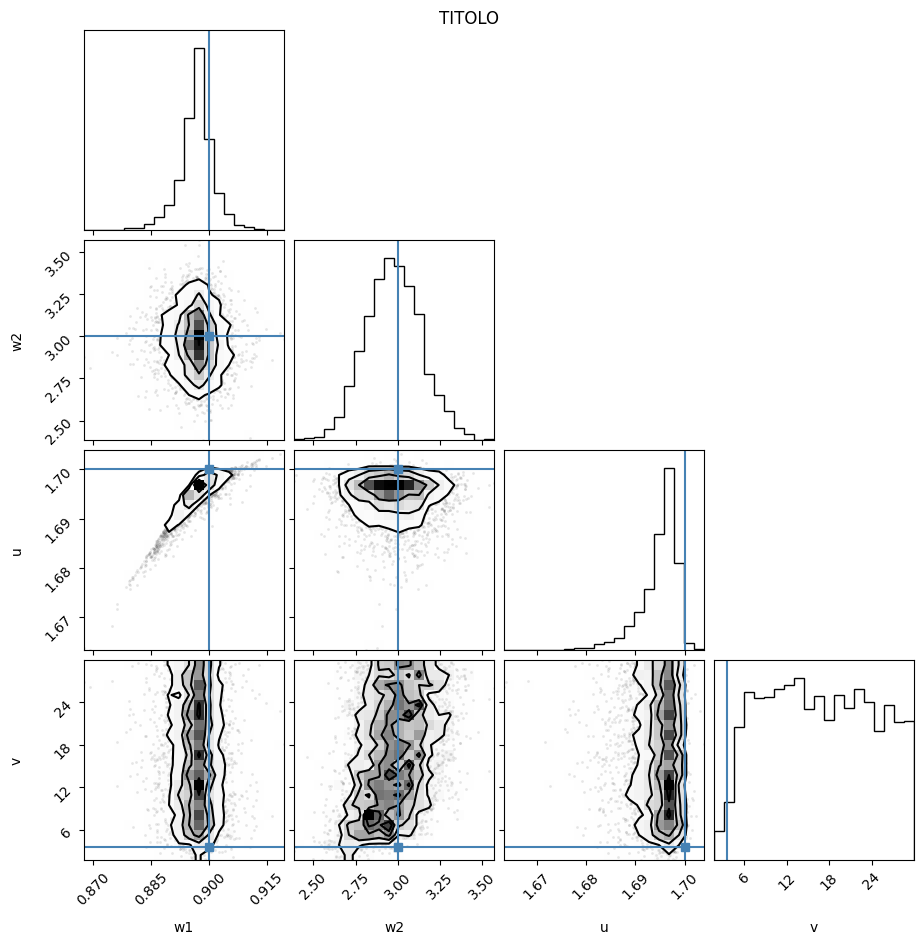

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [197]:
# Here we use the data generated from our model to estimate the parameters 

if not USE_DATASET:
    truth = evolver.model.fix_params.copy() # our parameters defined above
    labels =  evolver.model.fix_params_label.copy()

    nwalkers = 25 # number of walkers for the MCMC
    # We add some gaussian noise to our initial parameters
    guess = np.array(truth) + 1e-4 * np.random.randn(nwalkers, len(truth)) 

    spans = evolver.spans
    params_list = []
    for i in range(evolver.params.shape[1]): # the order is defined in the __init__ method of the model
        params_list.append(evolver.params[:, i][:-1])


    chain_lenght = 5000
    discard = 300
    thin_number = 35
    title="TITOLO"
    emcee_analysis(nwalkers=nwalkers, truths=truth, log_prob_fn=evolver.model.log_prob, args=(spans, *params_list),
                   guess = guess, chain_lenght=chain_lenght, labels=labels, use_pool=True, discard=discard,
                   thinning=thin_number, plot=True, title=title)


In [4]:
################### TO READ AND WRITE THE DATASET ###################
tanouchi25c_set = pd.read_csv("./dataset/Tanouchi25C.csv")
tanouchi37c_set = pd.read_csv("./dataset/Tanouchi37C.csv")
susman18_set = pd.read_csv("./dataset/Susman18_physical_units.csv")
tanouchi25c_set.df_name = "tanouchi25c"
tanouchi37c_set.df_name = "tanouchi37c"
susman18_set.df_name = "susman18"

names_to_dataset_map = {d.df_name: d for d in [tanouchi25c_set, tanouchi37c_set, susman18_set]}

df = tanouchi37c_set
WRITE_ON_FILE = True
OUTPUT = True
AUTO_FIND_P0 = True
FOLDER_PATH = "./results/"
DF_NAME = df.df_name
lineages = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
nwalkers = 25
chain_lenght = 3500
discard = 1000
thin_number = 35
model = Model1_2()
# no_model = 1
run_id = get_run_id(model.__class__)


params_mapping = {Model1_1: (['length_birth'], [slice(0, -1)]),
                  Model1_2: (['length_birth'], [slice(0, -1)]),
                  Model2: (['length_birth'], [slice(0, -1)]),
                  Model3: (["division_ratio", "length_final", "growth_rate"],
                           [slice(1, None), slice(None, -1), slice(1, None)])}

START = False
if USE_DATASET and START:

    columns = ["growth_rate"]
    df, df_deleted = filter_data(df, filter_cols=columns, show=False, remove_lineages=True)
    print(f"Eliminated {len(df_deleted)} rows")

    if AUTO_FIND_P0:
        truths = find_initial_params(df, model_name=model.__class__.__name__)
    else:

        if model.__class__ == Model3:
            a = 104.197
            b = 0.007
            c = 53.654
            d = 64.138
            w2 = 1.832
            u = 0.928
            v = 2.461
            truths = [a, b, c, d, w2, u, v]

        elif model.__class__ == Model1_2:
            w1, w2, u, v = 0.5, 6, 1.7, 3.5
            truths = [w1, w2, u, v]

        elif model.__class__ == Model2:
            w1, w2, u, v = 0.5, 6, 1.7, 3.5
            truths = [w1, w2, u, v]

        else:
            raise ValueError("Specify the truth for this model")

    labels = model.fix_params_label

    ndim = len(truths)
    guess = np.array(truths) + 1e-5 * np.random.randn(nwalkers, ndim)

    if not lineages:
        lineages = list(df['lineage_ID'].unique().astype(int))

    df = df[df["lineage_ID"].isin(lineages)]

    with open(FOLDER_PATH + f"run_{run_id}.txt", "w") as f:
        f.write(inspect.getsource(model.log_prior))

    print(f"######## ANALYZING DATASET {DF_NAME}, RUN_ID: {run_id} ########")
    print("Initial Parameters:")
    print(" ".join([f"{l}={v:.3f}" for v, l in zip(truths, labels)]))
    print("")

    for (lin_id,), df_lin in df.groupby(["lineage_ID"]):
        print(f"DATASET {DF_NAME}, LINEAGE: {lin_id}, n data: {len(df_lin)}")

        spans = df_lin["generationtime"][1:].to_numpy()
        params_list = []
        for param, slic in zip(*params_mapping[model.__class__]):
            params_list.append(df_lin[param][slic].to_numpy())

        title = f"{DF_NAME}  run_id: {run_id}  lineage: {lin_id}"
        result = emcee_analysis(nwalkers=nwalkers, truths=truths, log_prob_fn=model.log_prob,
                                args=(spans, *params_list), guess=guess, chain_lenght=chain_lenght,
                                labels=labels, use_pool=True, discard=discard, thinning=thin_number,
                                plot=OUTPUT)
        samples, flat_samples, result_dict = result

        if WRITE_ON_FILE:
            data = {"n_walkers": nwalkers, "ndim": ndim, "dataset": DF_NAME, "lineage_id": lin_id,
                    "truths": truths, "initial_guess": guess, "labels": labels,
                    # "spans": spans, "alphas": alphas, "kappas": kappas, "m_finals": m_finals,
                    "samples": samples, "tau": None, "thin_number": thin_number, "discard": discard,
                    "flat_samples": flat_samples, "result_dict": result_dict, "data_length": len(df_lin),
                    "data": [spans, *params_list],
                    "run_id": run_id
                    }

            filename = f"{DF_NAME}_{model.__class__.__name__}_run_{run_id:06}_lin_{int(lin_id):03}.bin"
            Path(FOLDER_PATH).mkdir(parents=True, exist_ok=True)

            with open(FOLDER_PATH + filename, "wb") as f:
                pickle.dump(data, f)

            print("File created: ", FOLDER_PATH + filename)
            print("----------------------------------------------------------")


In [ ]:
########### READ BACK THE FILE CREATED ########################
FOLDER_PATH = "./results/"
RUN_ID = "203697"


lineages = []
dataset_results_dict = read_files(FOLDER_PATH, df_name="tanouchi25c", run_id=RUN_ID, lineages=lineages)

for _, data in dataset_results_dict.items():
    df_name, lin_id = data["dataset"], data["lineage_id"]
    labels, samples, flat_samples = data["labels"], data["samples"], data["flat_samples"]
    result_dict, truths = data["result_dict"], data["truths"]

    title = f"DATASET {df_name}, lineage {lin_id}"

    print(title)
    plot_chains(samples, title=title, labels=labels)
    fig = corner.corner(flat_samples, labels=labels, truths=truths)
    fig.suptitle(title)
    plt.show()
    print_latex_result(list(result_dict.values()), labels)
    print("-------------------------------")



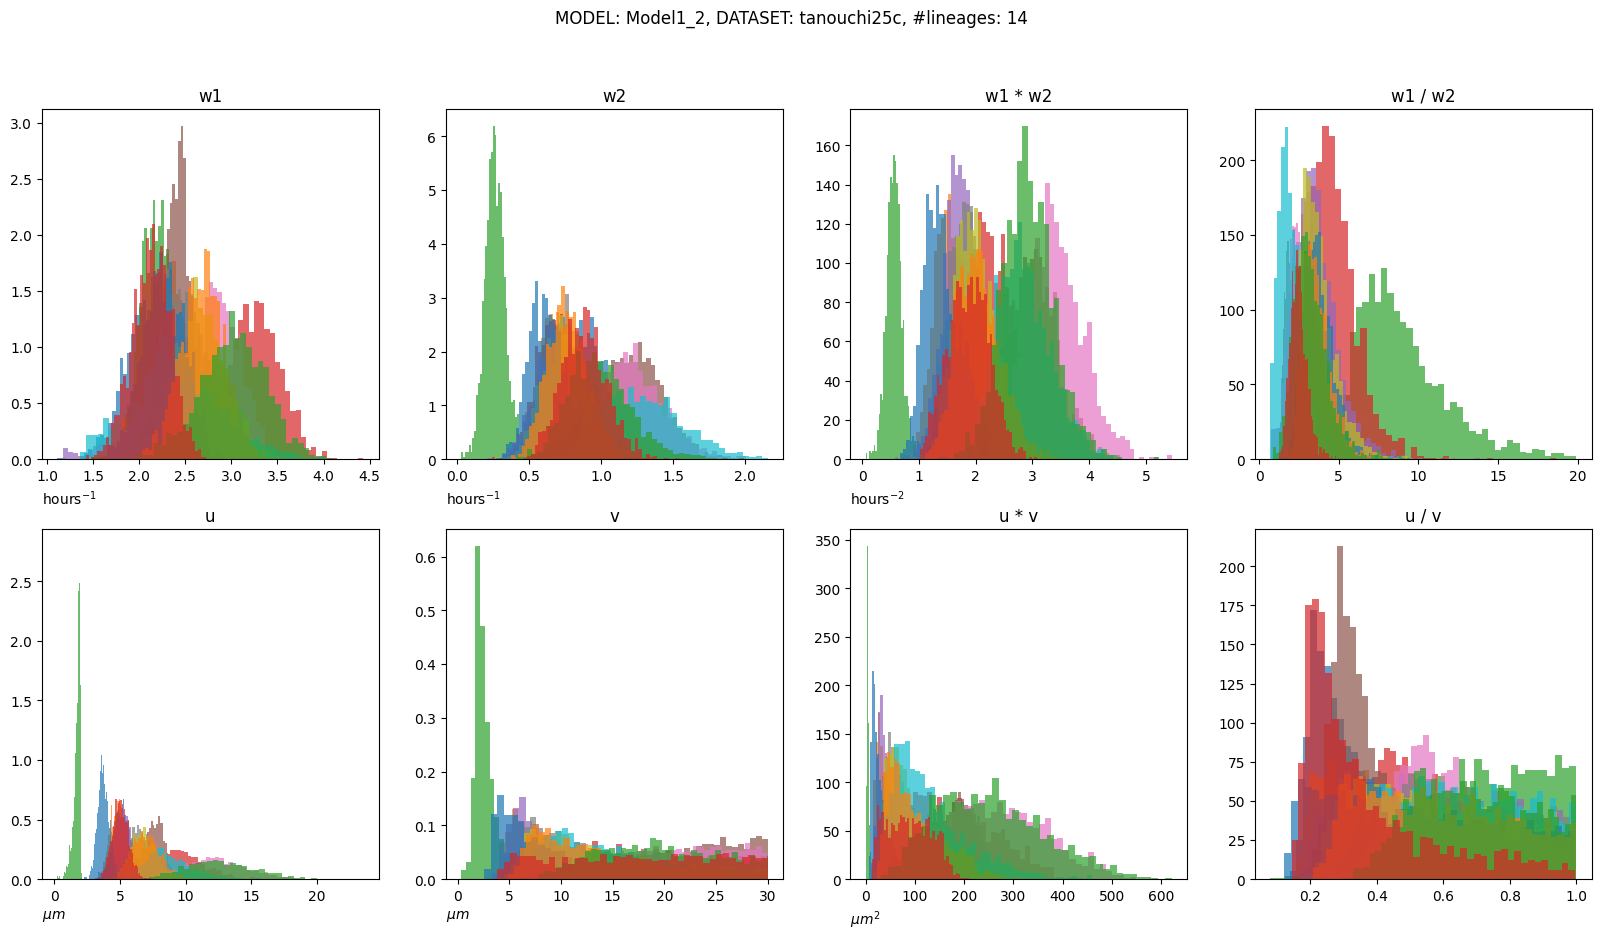

In [6]:
########### READ BACK THE FILE CREATED ########################
FOLDER_PATH = "./results/"
RUN_ID = "203697"

lineages = []
dataset_results_dict = read_files(FOLDER_PATH, df_name="tanouchi25c", run_id=RUN_ID, lineages=lineages)

ROWS, COLS = 2, 4
fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 5, ROWS * 5))

for i, data in enumerate(dataset_results_dict.values()):
    df_name, lin_id = data["dataset"], data["lineage_id"]
    labels, flat_samples = data["labels"], data["flat_samples"]
    result_dict, truths = data["result_dict"], data["truths"]
    
    nbins = int(np.sqrt(flat_samples.shape[0]))

    axs[0, 0].hist(flat_samples[:, 0], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    axs[0, 1].hist(flat_samples[:, 1], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    # plot w1 * w2
    axs[0, 2].hist(flat_samples[:, 0] * flat_samples[:, 1], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins)
    
    # plot w1 / w2
    ratio_samples = flat_samples[:, 0] / flat_samples[:, 1]
    ratio_samples = ratio_samples[ratio_samples < 20]
    axs[0, 3].hist(ratio_samples, label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins)
    
    axs[1, 0].hist(flat_samples[:, 2], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)

    axs[1, 1].hist(flat_samples[:, 3], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins, density=True)
    
    # plot u * v
    axs[1, 2].hist(flat_samples[:, 2] * flat_samples[:, 3], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins)
    
    # plot u / v
    axs[1, 3].hist(flat_samples[:, 2] / flat_samples[:, 3], label=f"Lin {lin_id}", alpha=0.7,
            bins=nbins)
    

for j, label in enumerate(labels):
    nbins = int(np.sqrt(flat_samples[:, j].shape[0]))
    index = (j // COLS, j % COLS)
    axs[index].set_title(label)

fig.suptitle(f"MODEL: {model.__class__.__name__}, DATASET: {df_name}, #lineages: {len(dataset_results_dict)}")
axs[0, 0].set_title('w1')
axs[0, 0].set_xlabel('hours$^{-1}$', loc = 'left')
axs[0, 1].set_title('w2')
axs[0, 1].set_xlabel('hours$^{-1}$', loc = 'left')
axs[0, 2].set_title('w1 * w2')
axs[0, 2].set_xlabel('hours$^{-2}$', loc = 'left')
axs[0, 3].set_title('w1 / w2')
axs[1, 0].set_title('u')
axs[1, 0].set_xlabel('$\mu m$', loc = 'left')
axs[1, 1].set_title('v')
axs[1, 1].set_xlabel('$\mu m$', loc = 'left')
axs[1, 2].set_title('u * v')
axs[1, 2].set_xlabel('$\mu m^2$', loc = 'left')
axs[1, 3].set_title('u / v');

Compatible file:  tanouchi25c  lineage:  1.0
Compatible file:  tanouchi25c  lineage:  2.0
Compatible file:  tanouchi25c  lineage:  3.0
Compatible file:  tanouchi25c  lineage:  4.0


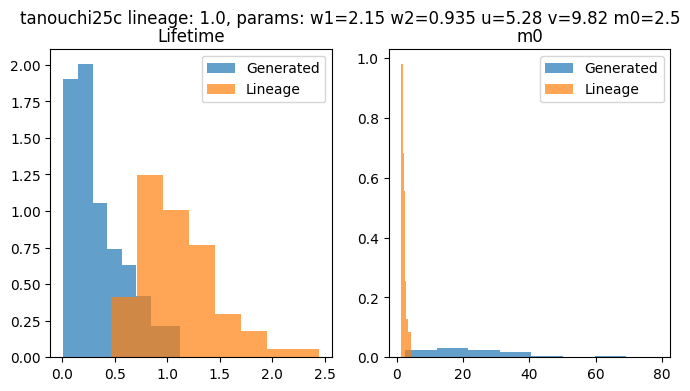

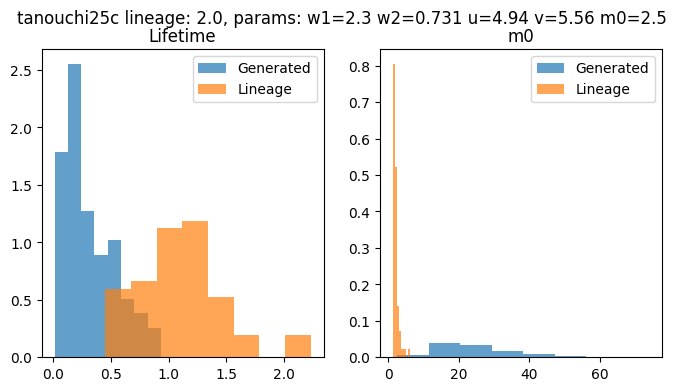

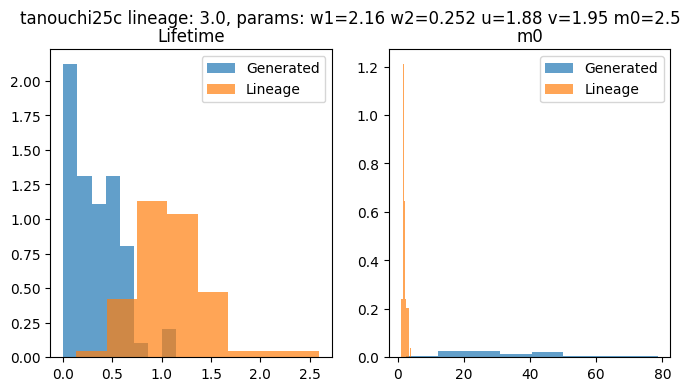

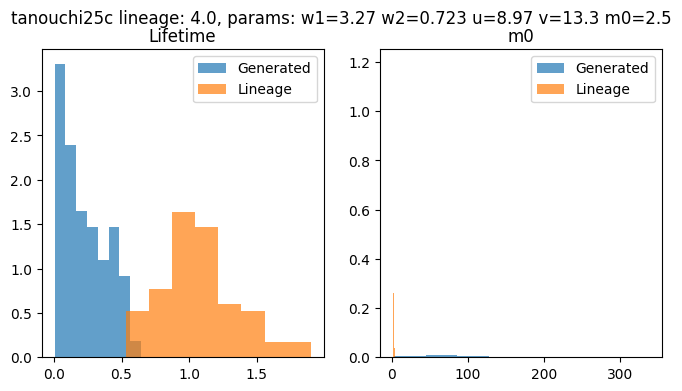

In [112]:
FOLDER_PATH = "./results/"
RUN_ID = "203697"

lineages = [1,2,3,4]
dataset_results_dict = read_files(FOLDER_PATH, df_name="tanouchi25c", run_id=RUN_ID, lineages=lineages)



for i, (_, data) in enumerate(dataset_results_dict.items()):
    df_name, lin_id = data["dataset"], data["lineage_id"]

    print("Compatible file: ", df_name, " lineage: ", lin_id)
    labels, flat_samples = data["labels"], data["flat_samples"]
    results, truths = data["result_dict"], data["truths"]
    data_length = data["data_length"]

    params = {"w1": results["w1"][0], "w2": results["w2"][0], "u": results["u"][0], "v": results["v"][0], "m0": 2.5}
    model_test = Model1_2(**params)
    params_txt = model_test.get_params_str()

    evolver_test = Evolver(model_test)
    evolver_test.evolve(n_div=data_length)

    model_data = [evolver_test.spans]
    for i in range(evolver_test.params.shape[1]):  # the order is defined in the __init__ method of the model
        model_data.append(evolver_test.params[:, i])

    ROWS, COLS = len(model_data) // 2 + len(model_data) % 2, 2
    fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 4))
    axs = axs.reshape(-1, COLS)

    params_labels = ["Lifetime"] + model_test.var_params_label
    for j, value in enumerate(data["data"]):
        nbins = int(np.sqrt(len(model_data[j])))

        index = (j // COLS, j % COLS)
        axs[index].hist(model_data[j], label="Generated", density=True, alpha=0.7, bins=nbins)
        axs[index].hist(value, label="Lineage", density=True, alpha=0.7, bins=nbins)
        axs[index].set_title(params_labels[j])
        axs[index].legend()

    fig.suptitle(f"{DF_NAME} lineage: {lin_id}, params: {params_txt}", wrap=True)
